In [1]:
from pathlib import Path
import pandas as pd

data_dir = Path("/lustre/scratch125/casm/team113da/projects/FUR/FUR_analysis/FUR_analysis_cat/human_comparison_figure/data")

# Directories for human cohorts
china_pan_cancer_dir = data_dir / "feb_2025_cohorts/china_pan_cancer"
msk_chord_dir = data_dir / "feb_2025_cohorts/MSK-CHORD"
msk_impact_dir = data_dir / "feb_2025_cohorts/MSK-IMPACT"
tcga_dir = data_dir / "feb_2025_cohorts/TCGA"

# Corresponding gene list files for each cohort
china_gene_list_file = china_pan_cancer_dir / "china_pan_cancer.gene_list.txt"
msk_chord_gene_list_file = msk_chord_dir / "msk_chord.gene_list.txt"
msk_impact_gene_list_file = msk_impact_dir / "msk_impact.gene_list.txt"
tcga_gene_list_file = tcga_dir / "tcga.gene_list.txt"

# Define a list of (cohort directory, gene list file) pairs.
cohorts = [
    (china_pan_cancer_dir, china_gene_list_file),
    (msk_chord_dir, msk_chord_gene_list_file),
    (msk_impact_dir, msk_impact_gene_list_file),
    (tcga_dir, tcga_gene_list_file)
]

def process_mutation_proportions_file(mutation_proportions_file: Path) -> pd.DataFrame:
    """
    Reads a mutation proportions file and extracts the Cohort, Tumour, Gene, and Freq.
    """
    df = pd.read_csv(mutation_proportions_file, sep='\t')
    file_name_parts = mutation_proportions_file.name.split('.')
    cohort_name = file_name_parts[0]
    tumour_type = file_name_parts[1]
    df["Cohort"] = cohort_name
    df["Tumour"] = tumour_type
    df["Freq"] = (
        df["Freq"]
        .str.replace('<', '')
        .str.replace('>', '')
        .str.rstrip('%')
        .astype(float) / 100
    )
    return df[["Cohort", "Tumour", "Gene", "Freq"]]

def process_cohort_dir(cohort_dir: Path, gene_list_file: Path) -> pd.DataFrame:
    """
    Processes all mutation proportions files in a cohort directory,
    merges with the full gene list to ensure one row per gene for each tumour type,
    and fills missing mutation frequencies with 0.
    """
    mutation_files = list(cohort_dir.glob("*.mutation_proportions.txt"))
    df_list = [process_mutation_proportions_file(file) for file in mutation_files]
    if df_list:
        df_cohort = pd.concat(df_list, ignore_index=True)
    else:
        df_cohort = pd.DataFrame(columns=["Cohort", "Tumour", "Gene", "Freq"])
    
    # Read the gene list (assumed one gene per line)
    gene_df = pd.read_csv(gene_list_file, header=None, names=["Gene"])
    
    # For every unique combination of Cohort and Tumour, merge with the full gene list.
    complete_rows = []
    for (cohort, tumour), group in df_cohort.groupby(["Cohort", "Tumour"]):
        merged = gene_df.merge(group, on="Gene", how="left")
        merged["Cohort"] = cohort
        merged["Tumour"] = tumour
        merged["Freq"] = merged["Freq"].fillna(0)
        complete_rows.append(merged)
    
    if complete_rows:
        return pd.concat(complete_rows, ignore_index=True)
    else:
        # If no mutation files exist, create an empty DataFrame with all genes and 0 frequency.
        gene_df["Freq"] = 0
        # If the cohort/tumour information is unknown, we can add placeholder values.
        gene_df["Cohort"] = cohort_dir.name
        gene_df["Tumour"] = "NA"
        return gene_df[["Cohort", "Tumour", "Gene", "Freq"]]

# Process each cohort and combine into a single dataframe.
all_cohort_dfs = [process_cohort_dir(cohort_dir, gene_file) for cohort_dir, gene_file in cohorts]
cbioportal_combined_mutation_proportions_df = pd.concat(all_cohort_dfs, ignore_index=True)

# Display the first few rows of the combined dataframe
print(cbioportal_combined_mutation_proportions_df.head())


     Gene            Cohort              Tumour   Freq
0    ABL1  china_pan_cancer  cholangiocarcinoma  0.008
1    ABL2  china_pan_cancer  cholangiocarcinoma  0.014
2  ACVR1B  china_pan_cancer  cholangiocarcinoma  0.016
3  ACVR2A  china_pan_cancer  cholangiocarcinoma  0.030
4  ADAM29  china_pan_cancer  cholangiocarcinoma  0.008


In [3]:
# Set directories and files
data_dir = Path("/lustre/scratch125/casm/team113da/projects/FUR/FUR_analysis/FUR_analysis_cat/human_comparison_figure/data")
fur_dir = data_dir / "fur_mafs"
fur_gene_list_file = fur_dir / "fur_cat.gene_list.txt"

# Get list of FUR MAF files
fur_mafs = list(fur_dir.glob('*.maf'))

# Mapping from study IDs to tumour types and T-cell lymphoma sample filter
STUDY_ID_TO_TUMOUR_TYPE_DICT = {
    "6555_2711": "lung_carcinoma",
    "6711_2820": "cscc",
    "6712_2822": "oscc",
    "6841_2964": "meningioma",
    "6864_2965": "pancreatic_carcinoma",
    "6945_3142": "cholangiocarcinoma",
    "6973_2987": "osteosarcoma",
    "6982_3135": "b_cell_lymphoma",
    "6990_3065": "mammary_carcinoma",
    "7040_3064": "basal_cell_carcinoma",
    "7097_3073": "colorectal_carcinoma",
    "7098_3140": "glioma"
}

T_CELL_LYMPHOMA_SAMPLES = [
    'CATD0572a', 'CATD0574a', 'CATD0575a',
    'CATD0578a', 'CATD0579a', 'CATD0580a', 
    'CATD0581a', 'CATD0585a', 'CATD0587a',
    'CATD0588a', 'CATD0592a', 'CATD0593a',
    'CATD0596a', 'CATD0598a', 'CATD0601a',
    'CATD0603a', 'CATD0606a', 'CATD0608a',
    'CATD0610a', 'CATD0678a', 'CATD0679a',
    'CATD0680a', 'CATD0682a', 'CATD0683a', 
    'CATD0684a', 'CATD0687a', 'CATD0721a',
    'CATD0722a', 'CATD0724a'
]

# Process each FUR MAF file
dataframes = []
for file in fur_mafs:
    # Extract study ID from file name (assumes filename format includes 'matched_<study_id>.')
    study_id = file.stem.split('.')[0].split('matched_')[1]
    # Skip a specific study if needed
    if study_id == '6713_2821':
        continue
    tumour_type = STUDY_ID_TO_TUMOUR_TYPE_DICT.get(study_id)
    df = pd.read_csv(file, sep='\t')
    df['Tumour'] = tumour_type
    # For lymphoma, drop unwanted T-cell samples
    if tumour_type == "lymphoma":
        df = df[~df["Sanger_DNA_ID"].isin(T_CELL_LYMPHOMA_SAMPLES)]
    dataframes.append(df)

# Combine all FUR MAF dataframes
fur_combined_df = pd.concat(dataframes, ignore_index=True)

def calculate_mutation_proportion_from_maf_df(df):
    """
    Calculate the proportion of unique samples with mutations per gene in each tumour type.
    If Hugo_Symbol is '-', use the 'Gene' column instead.
    """
    required_columns = {'Hugo_Symbol', 'Tumour', 'Tumor_Sample_Barcode', 'Gene'}
    assert required_columns.issubset(df.columns), f"Missing columns: {required_columns - set(df.columns)}"
    
    # Use Hugo_Symbol unless it is '-', in which case use Gene
    df['Gene_Final'] = df['Hugo_Symbol'].where(df['Hugo_Symbol'] != '-', df['Gene'])
    
    # Count total unique samples per tumour type
    total_samples = df.groupby('Tumour')['Tumor_Sample_Barcode'].nunique()
    # Count unique samples mutated in each gene per tumour type
    mutated = df.groupby(['Gene_Final', 'Tumour'])['Tumor_Sample_Barcode'].nunique()
    
    # Calculate the mutation proportion
    proportions = mutated / total_samples
    result = proportions.reset_index()
    result.columns = ['Gene', 'Tumour', 'Freq']
    result['Cohort'] = 'FUR'
    return result[['Cohort', 'Gene', 'Tumour', 'Freq']]

# Calculate mutation proportions from the combined MAF data
fur_mutation_proportion_df = calculate_mutation_proportion_from_maf_df(fur_combined_df)

def merge_with_gene_list(proportion_df, gene_list_file, cohort='FUR'):
    """
    Ensure every gene in the provided gene list appears for each tumour type.
    If a gene is missing in the mutation proportions, its frequency is set to 0.
    """
    gene_df = pd.read_csv(gene_list_file, header=None, names=["Gene"])
    merged_list = []
    for tumour in proportion_df['Tumour'].unique():
        df_tumour = proportion_df[proportion_df['Tumour'] == tumour]
        merged = gene_df.merge(df_tumour, on="Gene", how="left")
        merged["Tumour"] = tumour  # Set tumour type
        merged["Cohort"] = cohort
        merged["Freq"] = merged["Freq"].fillna(0)
        merged_list.append(merged)
    return pd.concat(merged_list, ignore_index=True)

# Merge the FUR mutation proportions with the full FUR gene list
fur_mutation_proportion_full_df = merge_with_gene_list(fur_mutation_proportion_df, fur_gene_list_file, cohort='FUR')

# Display the first few rows
print(fur_mutation_proportion_full_df.head())


       Gene Cohort              Tumour      Freq
0      ABI1    FUR  cholangiocarcinoma  0.035714
1      ABL1    FUR  cholangiocarcinoma  0.071429
2      ABL2    FUR  cholangiocarcinoma  0.035714
3  ABRAXAS1    FUR  cholangiocarcinoma  0.035714
4     ACKR3    FUR  cholangiocarcinoma  0.035714


In [4]:
# Merge the cbioportal and FUR dataframes on 'Gene' and 'Tumour'
merged_df = pd.merge(
    cbioportal_combined_mutation_proportions_df,
    fur_mutation_proportion_df,
    on=['Gene', 'Tumour'],
    how='inner',  # inner join to keep only matching genes/tumour types
    suffixes=('_cbio', '_fur')
)

print(merged_df.head())

     Gene       Cohort_cbio              Tumour  Freq_cbio Cohort_fur  \
0    ABL1  china_pan_cancer  cholangiocarcinoma      0.008        FUR   
1    ABL2  china_pan_cancer  cholangiocarcinoma      0.014        FUR   
2  ACVR1B  china_pan_cancer  cholangiocarcinoma      0.016        FUR   
3  ACVR2A  china_pan_cancer  cholangiocarcinoma      0.030        FUR   
4  ADGRA2  china_pan_cancer  cholangiocarcinoma      0.016        FUR   

   Freq_fur  
0  0.071429  
1  0.035714  
2  0.035714  
3  0.071429  
4  0.035714  


In [ ]:
import matplotlib.pyplot as plt

# Loop over each unique cBioPortal cohort
for cbio_cohort in cbioportal_combined_mutation_proportions_df['Cohort'].unique():
    # Subset the cBioPortal dataframe to the current cohort
    cbio_cohort_df = cbioportal_combined_mutation_proportions_df[
        cbioportal_combined_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    # Loop over each tumour type within this cohort
    for tumour in cbio_cohort_df['Tumour'].unique():
        # Subset cBioPortal data for the current tumour type
        cbio_subset = cbio_cohort_df[cbio_cohort_df['Tumour'] == tumour]
        # Subset FUR data for the same tumour type
        fur_subset = fur_mutation_proportion_full_df[fur_mutation_proportion_full_df['Tumour'] == tumour]
        
        # Merge on 'Gene' so that we compare the same gene in both datasets
        merged_df = pd.merge(cbio_subset, fur_subset, on="Gene", suffixes=('_cbio', '_fur'))
        
        # If there are no overlapping genes, skip plotting
        if merged_df.empty:
            print(f"No matching genes for {cbio_cohort} in {tumour}.")
            continue

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(merged_df['Freq_cbio'], merged_df['Freq_fur'], alpha=0.7, edgecolor='k')
        plt.xlabel(f'{cbio_cohort} Mutation Frequency')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(f'Mutation Frequencies in {tumour}\n{cbio_cohort} vs FUR')
        
        # Label each point with its gene name
        for _, row in merged_df.iterrows():
            # Slightly offset the text for clarity
            plt.text(row['Freq_cbio'] * 1.01, row['Freq_fur'] * 1.01, 
                     row['Gene'], fontsize=8, ha='left', va='bottom')
        
        # Plot a diagonal line for reference
        max_val = max(merged_df['Freq_cbio'].max(), merged_df['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop over each unique cBioPortal cohort
for cbio_cohort in cbioportal_combined_mutation_proportions_df['Cohort'].unique():
    # Filter the cBioPortal data for this cohort
    cbio_cohort_df = cbioportal_combined_mutation_proportions_df[
        cbioportal_combined_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    # Create an empty list to collect merged data for all tumour types within this cohort
    merged_list = []
    
    # Loop over each tumour type in this cohort
    for tumour in cbio_cohort_df['Tumour'].unique():
        # Subset the cBioPortal data for the current tumour type
        cbio_subset = cbio_cohort_df[cbio_cohort_df['Tumour'] == tumour]
        # Subset the FUR data for the same tumour type
        fur_subset = fur_mutation_proportion_full_df[fur_mutation_proportion_full_df['Tumour'] == tumour]
        
        # Merge on both 'Gene' and 'Tumour' to preserve the tumour column
        merged_df = pd.merge(
            cbio_subset,
            fur_subset,
            on=["Gene", "Tumour"],
            suffixes=('_cbio', '_fur')
        )
        
        # Only add non-empty merges
        if not merged_df.empty:
            merged_list.append(merged_df)
    
    # Combine the merged data from all tumour types (if any)
    if merged_list:
        cohort_merged = pd.concat(merged_list, ignore_index=True)
        
        # Create a scatter plot with points colored by tumour type using seaborn
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=cohort_merged, 
            x='Freq_cbio', 
            y='Freq_fur', 
            hue='Tumour', 
            palette='tab10',
            s=80,
            edgecolor='k'
        )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(f'Mutation Frequencies Comparison: {cbio_cohort} vs FUR (All Tumour Types)')
        
        # Plot a reference diagonal (y = x) line
        max_val = max(cohort_merged['Freq_cbio'].max(), cohort_merged['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        
        # Move the legend outside the plot so it does not overlap the data points
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No overlapping gene data found for {cbio_cohort}.")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -------------- THRESHOLDS --------------
LOW_THRESHOLD       = 0.2   # Exclude genes that are < 0.05 in BOTH cohorts
SIMILAR_REL_DIFF    = 0.05   # <= 5% difference = "highly similar"
DIFFERENT_REL_DIFF  = 0.20   # >= 20% difference = "highly different"

# Loop over each unique cBioPortal cohort
for cbio_cohort in cbioportal_combined_mutation_proportions_df['Cohort'].unique():
    
    # Filter the cBioPortal data for this cohort
    cbio_cohort_df = cbioportal_combined_mutation_proportions_df[
        cbioportal_combined_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    # Collect merged data for all tumour types within this cohort
    merged_list = []
    
    # Loop over each tumour type in this cohort
    for tumour in cbio_cohort_df['Tumour'].unique():
        # Subset the cBioPortal data for the current tumour type
        cbio_subset = cbio_cohort_df[cbio_cohort_df['Tumour'] == tumour]
        # Subset the FUR data for the same tumour type
        fur_subset = fur_mutation_proportion_full_df[fur_mutation_proportion_full_df['Tumour'] == tumour]
        
        # Merge on both 'Gene' and 'Tumour' to preserve the tumour column
        merged_df = pd.merge(
            cbio_subset,
            fur_subset,
            on=["Gene", "Tumour"],
            suffixes=('_cbio', '_fur')
        )
        
        if not merged_df.empty:
            merged_list.append(merged_df)
    
    # If we have merged data for this cohort
    if merged_list:
        cohort_merged = pd.concat(merged_list, ignore_index=True)
        
        # -------- 1) Compute RELATIVE DIFFERENCE --------
        # rel_diff = |Freq_cbio - Freq_fur| / max(Freq_cbio, Freq_fur)
        # Guard against division by zero by replacing 0 with NaN
        cohort_merged['rel_diff'] = (
            (cohort_merged['Freq_cbio'] - cohort_merged['Freq_fur']).abs() /
            cohort_merged[['Freq_cbio', 'Freq_fur']].max(axis=1).replace(0, np.nan)
        )
        
        # -------- 2) Define "highly similar" & "highly different" masks --------
        # Basic masks using relative difference
        mask_similar = (cohort_merged['rel_diff'] <= SIMILAR_REL_DIFF)
        mask_diff    = (cohort_merged['rel_diff'] >= DIFFERENT_REL_DIFF)
        
        # -------- 3) Exclude genes that are low in BOTH cohorts (bottom-left) --------
        # i.e., do NOT highlight if Freq_cbio < LOW_THRESHOLD AND Freq_fur < LOW_THRESHOLD
        mask_not_both_low = ~(
            (cohort_merged['Freq_cbio'] < LOW_THRESHOLD) &
            (cohort_merged['Freq_fur'] < LOW_THRESHOLD)
        )
        
        # Combine them: only highlight points that are either "similar" or "different"
        # AND also not low in both
        mask_similar_filtered = mask_similar & mask_not_both_low
        mask_diff_filtered    = mask_diff & mask_not_both_low
        
        # -------------- PLOT 1: HIGHLY SIMILAR --------------
        plt.figure(figsize=(8, 6))
        
        # Plot ALL points with lower alpha
        sns.scatterplot(
            data=cohort_merged,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=0.3,  # lower alpha for background
            legend='brief'
        )
        
        # Overlay the "similar" points (excluding bottom-left) with higher alpha
        sns.scatterplot(
            data=cohort_merged[mask_similar_filtered],
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=1.0,  # highlight
            legend=False
        )
        
        # Optionally label the "similar" points
        for i, row in cohort_merged[mask_similar_filtered].iterrows():
            plt.text(
                x=row['Freq_cbio'] + 0.002,
                y=row['Freq_fur'] + 0.002,
                s=row['Gene'],
                fontsize=8
            )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(
            f'Highly Similar Genes (Rel Diff <= {SIMILAR_REL_DIFF:.0%}), '
            f'Excluding Bottom-Left:\n{cbio_cohort} vs FUR'
        )
        
        # Reference diagonal
        max_val = max(cohort_merged['Freq_cbio'].max(), cohort_merged['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # -------------- PLOT 2: HIGHLY DIFFERENT --------------
        plt.figure(figsize=(8, 6))
        
        # Plot ALL points with lower alpha
        sns.scatterplot(
            data=cohort_merged,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=0.3,  # lower alpha for background
            legend='brief'
        )
        
        # Overlay the "different" points (excluding bottom-left) with higher alpha
        sns.scatterplot(
            data=cohort_merged[mask_diff_filtered],
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=1.0,  # highlight
            legend=False
        )
        
        # Optionally label the "different" points
        for i, row in cohort_merged[mask_diff_filtered].iterrows():
            plt.text(
                x=row['Freq_cbio'] + 0.002,
                y=row['Freq_fur'] + 0.002,
                s=row['Gene'],
                fontsize=8
            )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(
            f'Highly Different Genes (Rel Diff >= {DIFFERENT_REL_DIFF:.0%}), '
            f'Excluding Bottom-Left:\n{cbio_cohort} vs FUR'
        )
        
        # Reference diagonal
        max_val = max(cohort_merged['Freq_cbio'].max(), cohort_merged['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"No overlapping gene data found for {cbio_cohort}.")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from adjustText import adjust_text  # pip install adjustText

# Define separate low-frequency thresholds for x (tcga) and y (FUR)
X_LOW_THRESHOLD = 0.2  # tcga (Freq_cbio) low threshold
Y_LOW_THRESHOLD = 0.2  # FUR (Freq_fur) low threshold

# Loop over each unique cBioPortal cohort
for cbio_cohort in cbioportal_combined_mutation_proportions_df['Cohort'].unique():
    
    # Filter the cBioPortal data for this cohort
    cbio_cohort_df = cbioportal_combined_mutation_proportions_df[
        cbioportal_combined_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    # Collect merged data for all tumour types within this cohort
    merged_list = []
    
    for tumour in cbio_cohort_df['Tumour'].unique():
        # Subset the cBioPortal data for the current tumour type
        cbio_subset = cbio_cohort_df[cbio_cohort_df['Tumour'] == tumour]
        # Subset the FUR data for the same tumour type
        fur_subset = fur_mutation_proportion_full_df[
            fur_mutation_proportion_full_df['Tumour'] == tumour
        ]
        
        # Merge on both 'Gene' and 'Tumour'
        merged_df = pd.merge(
            cbio_subset,
            fur_subset,
            on=["Gene", "Tumour"],
            suffixes=('_cbio', '_fur')
        )
        
        if not merged_df.empty:
            merged_list.append(merged_df)
    
    if merged_list:
        # Combine data from all tumour types
        cohort_merged = pd.concat(merged_list, ignore_index=True)
        
        # Define a mask for "interesting" points:
        # Points are considered not interesting if they are below X_LOW_THRESHOLD on the x-axis
        # AND below Y_LOW_THRESHOLD on the y-axis.
        mask_interesting = ~(
            (cohort_merged['Freq_cbio'] < X_LOW_THRESHOLD) &
            (cohort_merged['Freq_fur'] < Y_LOW_THRESHOLD)
        )
        
        plt.figure(figsize=(8, 6))
        
        # 1. Plot all points with lower opacity (faint background)
        sns.scatterplot(
            data=cohort_merged,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=0.3,
            legend='brief'
        )
        
        # 2. Overlay the "interesting" points (not in bottom-left) with full opacity
        sns.scatterplot(
            data=cohort_merged[mask_interesting],
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=1.0,
            legend=False
        )
        
        # 3. Add labels for the interesting points
        texts = []
        for i, row in cohort_merged[mask_interesting].iterrows():
            txt = plt.text(
                row['Freq_cbio'] + 0.002,  # initial slight x offset
                row['Freq_fur'] + 0.002,   # initial slight y offset
                row['Gene'],
                fontsize=8
            )
            texts.append(txt)
        
        # Adjust the text labels so they do not overlap the points.
        # We specify 'only_move' to restrict movement to the text and use increased expand and force parameters.
        adjust_text(
            texts,
            arrowprops=dict(arrowstyle='->', color='gray', lw=1),
            avoid_points=True,
            expand_text=(100, 100),
            expand_points=(4, 4),
            force_text=1.0,
            force_points=0.5,
            only_move={'text': 'xy'},
            lim=1000
        )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency (tcga)')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(
            f'Mutation Frequencies ({cbio_cohort} vs FUR)\n'
            f'Highlighting points where Freq_cbio >= {X_LOW_THRESHOLD} or Freq_fur >= {Y_LOW_THRESHOLD}'
        )
        
        # Add a reference diagonal line (y = x)
        max_val = max(cohort_merged['Freq_cbio'].max(), cohort_merged['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"No overlapping gene data found for {cbio_cohort}.")


31 [ 0.51991385 -0.1305643 ]
38 [-0.66869905 -0.77185867]
7 [0.45121494 0.49854812]
42 [0.98663426 0.54042981]
26 [ 0.66859873 -0.44187451]
43 [0.59038245 0.45330152]


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


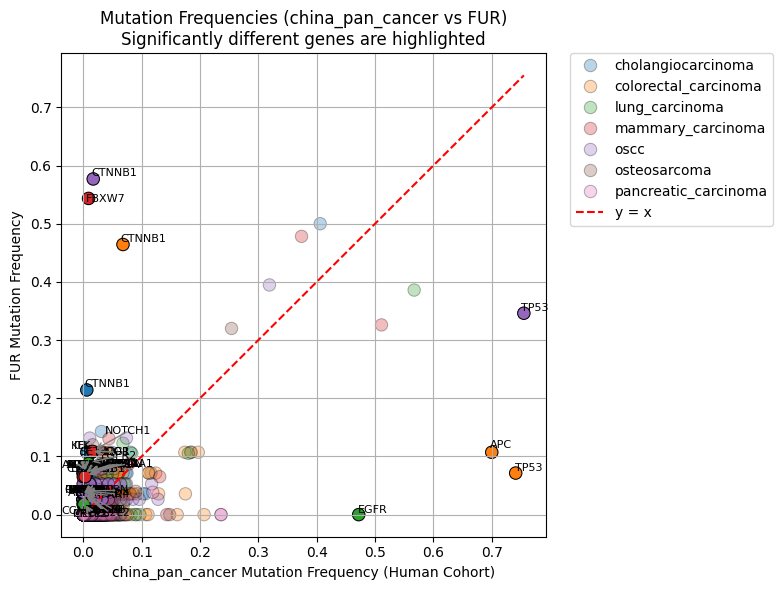

27 [-0.8408921   0.22649635]
81 [-0.88531335  0.34441905]
314 [-0.776756   -0.90867014]
324 [ 0.52892    -0.14316568]
123 [0.89269108 0.61450146]
158 [-0.81185394 -0.00249857]
23 [ 0.32796422 -0.77488115]
78 [ 0.65568831 -0.43542681]
205 [ 0.29028689 -0.06793839]
217 [-0.21340128  0.31905985]
144 [-0.28119349  0.52458671]
170 [0.633224   0.27528574]
235 [-0.69611982 -0.31152026]
264 [-0.11283817 -0.82996382]
109 [-0.62998726 -0.86860828]
132 [0.75892296 0.28192125]
301 [0.84295877 0.91047561]
334 [-0.64414523  0.74419835]
39 [ 0.52032921 -0.81820689]
80 [ 0.927712   -0.79240273]
40 [0.62748482 0.43683848]
42 [-0.19050942 -0.89091417]
124 [-0.27970281 -0.59918524]
148 [ 0.66144398 -0.40344955]
29 [-0.51428562 -0.37708037]
66 [0.53152139 0.71977341]
210 [-0.85784308 -0.14284111]
211 [-0.86354104 -0.4392038 ]
61 [ 0.00106219 -0.637627  ]
88 [-0.35317074 -0.70636759]
272 [-0.05727802 -0.86775555]
285 [-0.35767901 -0.84265751]
171 [-0.76898755  0.99283864]
184 [ 0.29762692 -0.13751651]
219 

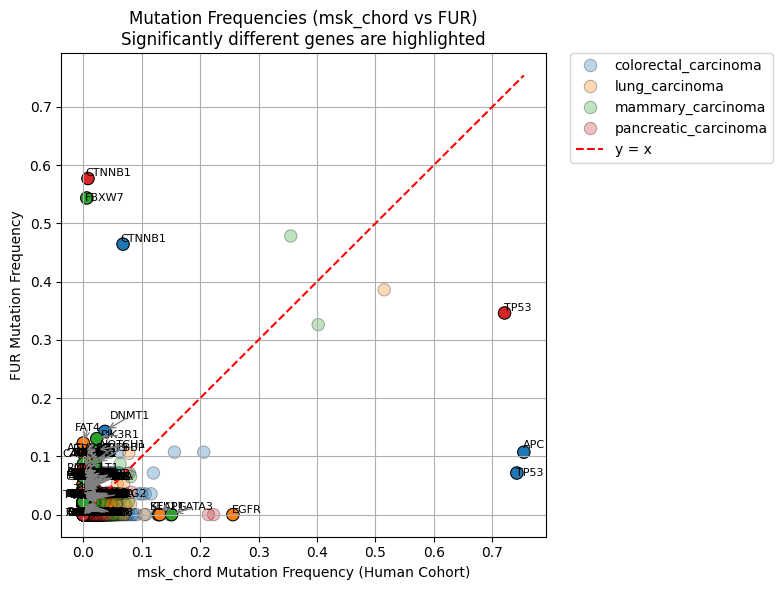

18 [0.22497164 0.67797208]
25 [ 0.22942923 -0.48319599]


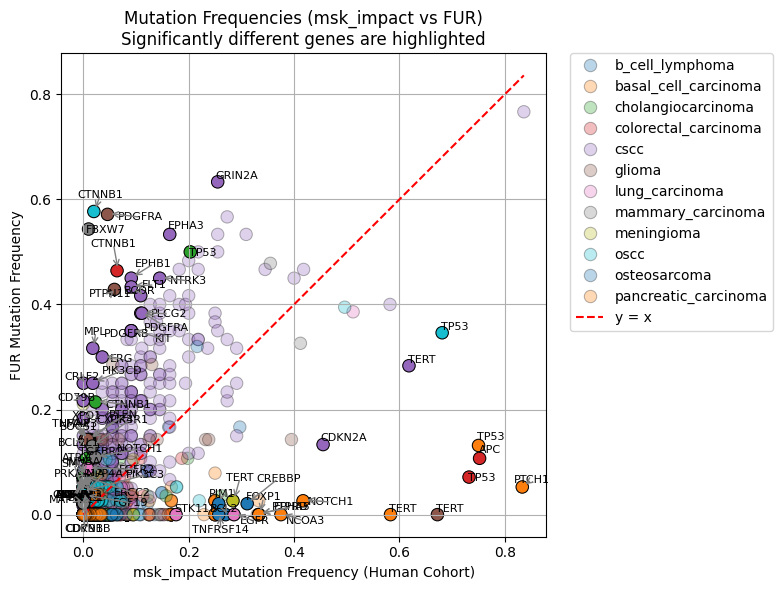

6 [-0.2062997   0.46621742]
7 [-0.46723585  0.64170082]
7 [-0.93740336  0.49819255]
18 [ 0.85092822 -0.11761652]
2 [-4.53152273e-04  4.60033476e-01]
8 [-0.05337762 -0.09773061]


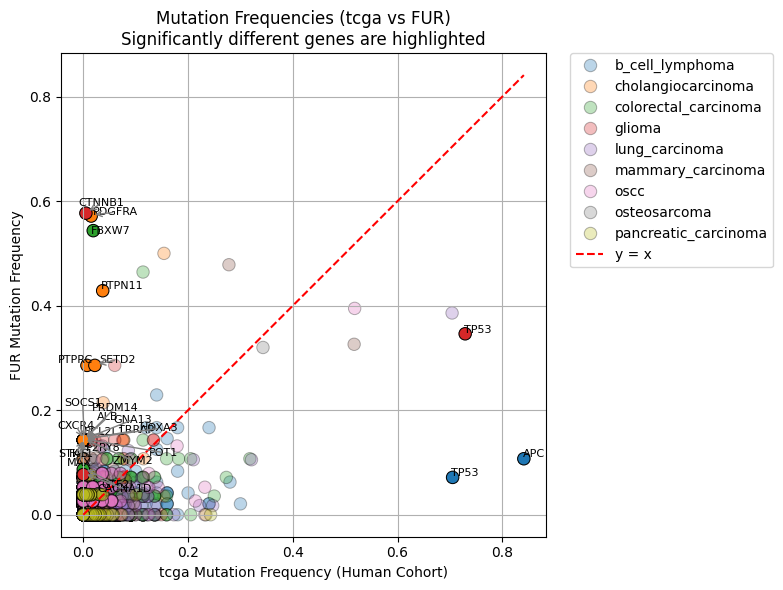

In [4]:
import numpy as np
import math
import pandas as pd
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# ----------------------------------------------------------------
# Define sample counts for cBioPortal studies.
cbio_total_samples = {
    # tcga
    ("tcga", "pancreatic_carcinoma"): 285,
    ("tcga", "cholangiocarcinoma"): 26,
    ("tcga", "mammary_carcinoma"): 211,
    ("tcga", "glioma"): 150,
    ("tcga", "b_cell_lymphoma"): 50,
    ("tcga", "osteosarcoma"): 35,
    ("tcga", "oscc"): 56,
    ("tcga", "colorectal_carcinoma"): 44,
    ("tcga", "lung_carcinoma"): 71,

    # msk_impact
    ("msk_impact", "lung_carcinoma"): 1357,
    ("msk_impact", "mammary_carcinoma"): 1312,
    ("msk_impact", "colorectal_carcinoma"): 965,
    ("msk_impact", "glioma"): 541,
    ("msk_impact", "pancreatic_carcinoma"): 398,
    ("msk_impact", "cholangiocarcinoma"): 172,
    ("msk_impact", "oscc"): 141,
    ("msk_impact", "cscc"): 55,
    ("msk_impact", "basal_cell_carcinoma"): 12,
    ("msk_impact", "osteosarcoma"): 37,
    ("msk_impact", "b_cell_lymphoma"): 74,
    ("msk_impact", "meningioma"): 21,

    # msk_chord
    ("msk_chord", "lung_carcinoma"): 6434,
    ("msk_chord", "colorectal_carcinoma"): 5389,
    ("msk_chord", "mammary_carcinoma"): 5200,
    ("msk_chord", "pancreatic_carcinoma"): 2746,

    # china_pan_cancer
    ("china_pan_cancer", "lung_carcinoma"): 2018,
    ("china_pan_cancer", "colorectal_carcinoma"): 1220,
    ("china_pan_cancer", "cholangiocarcinoma"): 508,
    ("china_pan_cancer", "pancreatic_carcinoma"): 461,
    ("china_pan_cancer", "mammary_carcinoma"): 321,
    ("china_pan_cancer", "osteosarcoma"): 122,
    ("china_pan_cancer", "oscc"): 94,
}

# Compute total sample counts per tumour type for FUR using the MAF data.
# (Assumes that 'fur_combined_df' has been computed previously.)
fur_total_samples = fur_combined_df.groupby('Tumour')['Tumor_Sample_Barcode'].nunique().to_dict()

def two_proportion_ztest(x1, n1, x2, n2):
    """
    Perform a two-proportion z-test comparing proportions p1 = x1/n1 and p2 = x2/n2.
    Returns the two-tailed p-value.
    """
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return 1.0  # no variability: return non-significant
    z = (p1 - p2) / se
    return 2 * (1 - norm.cdf(abs(z)))

# ----------------------------------------------------------------
# Set a threshold below which we do not label points (e.g., 5%)
LABEL_THRESHOLD = 0.01

for cbio_cohort in cbioportal_combined_mutation_proportions_df['Cohort'].unique():
    cbio_cohort_df = cbioportal_combined_mutation_proportions_df[
        cbioportal_combined_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    merged_list = []
    for tumour in cbio_cohort_df['Tumour'].unique():
        cbio_subset = cbio_cohort_df[cbio_cohort_df['Tumour'] == tumour]
        fur_subset = fur_mutation_proportion_full_df[fur_mutation_proportion_full_df['Tumour'] == tumour]
        
        merged_df = pd.merge(
            cbio_subset,
            fur_subset,
            on="Gene",
            suffixes=('_cbio', '_fur')
        )
        merged_df['Tumour'] = tumour
        
        if not merged_df.empty:
            merged_list.append(merged_df)
    
    if merged_list:
        cohort_merged = pd.concat(merged_list, ignore_index=True)
        
        # Compute p-values as before
        def compute_p_val(row):
            tumour = row['Tumour']
            n1 = cbio_total_samples.get((cbio_cohort, tumour), np.nan)
            n2 = fur_total_samples.get(tumour, np.nan)
            if pd.isna(n1) or pd.isna(n2) or n1 == 0 or n2 == 0:
                return 1.0
            x1 = round(row['Freq_cbio'] * n1)
            x2 = round(row['Freq_fur'] * n2)
            return two_proportion_ztest(x1, n1, x2, n2)
        
        cohort_merged['p_val'] = cohort_merged.apply(compute_p_val, axis=1)
        
        # Multiple testing correction
        _, pvals_corrected, _, _ = multipletests(cohort_merged['p_val'], alpha=0.05, method='fdr_bh')
        cohort_merged['p_adj'] = pvals_corrected
        cohort_merged['significant'] = cohort_merged['p_adj'] < 0.05
        
        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=cohort_merged,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=0.3,    # background points
            legend='brief'
        )
        
        sig_data = cohort_merged[cohort_merged['significant']]
        sns.scatterplot(
            data=sig_data,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            palette='tab10',
            s=80,
            edgecolor='k',
            alpha=1.0,    # highlight significant points
            legend=False
        )
        
        # Filter out points with very low frequencies in both cohorts
        # i.e., skip labeling if both Freq_cbio and Freq_fur < LABEL_THRESHOLD
        sig_data_for_label = sig_data[
            ~(
                (sig_data['Freq_cbio'] < LABEL_THRESHOLD) &
                (sig_data['Freq_fur'] < LABEL_THRESHOLD)
            )
        ]
        
        # Label only these filtered points
        texts = []
        for _, row in sig_data_for_label.iterrows():
            txt = plt.text(
                row['Freq_cbio'] + 0.002,
                row['Freq_fur'] + 0.002,
                row['Gene'],
                fontsize=8
            )
            texts.append(txt)
        
        adjust_text(
            texts,
            arrowprops=dict(arrowstyle='->', color='gray', lw=1),
            avoid_points=True,
            expand_text=(1.1, 1.1),
            expand_points=(2, 2),
            force_text=1.0,
            force_points=0.5,
            only_move={'text': 'xy'},
            lim=1000
        )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency (Human Cohort)')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(
            f'Mutation Frequencies ({cbio_cohort} vs FUR)\n'
            'Significantly different genes are highlighted'
        )
        max_val = max(cohort_merged['Freq_cbio'].max(), cohort_merged['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.grid(True)
        plt.tight_layout()
        
        # Save plot to a PDF file
        pdf_filename = f"Mutation_Frequencies_{cbio_cohort}_vs_FUR.pdf"
        plt.savefig(pdf_filename)
        plt.show()
    else:
        print(f"No overlapping gene data found for {cbio_cohort}.")


     Gene            Cohort              Tumour   Freq
0    ABL1  china_pan_cancer  cholangiocarcinoma  0.008
1    ABL2  china_pan_cancer  cholangiocarcinoma  0.014
2  ACVR1B  china_pan_cancer  cholangiocarcinoma  0.016
3  ACVR2A  china_pan_cancer  cholangiocarcinoma  0.030
4  ADAM29  china_pan_cancer  cholangiocarcinoma  0.008
       Gene Cohort              Tumour      Freq
0      ABI1    FUR  cholangiocarcinoma  0.035714
1      ABL1    FUR  cholangiocarcinoma  0.071429
2      ABL2    FUR  cholangiocarcinoma  0.035714
3  ABRAXAS1    FUR  cholangiocarcinoma  0.035714
4     ACKR3    FUR  cholangiocarcinoma  0.035714
     Gene       Cohort_cbio              Tumour  Freq_cbio Cohort_fur  \
0    ABL1  china_pan_cancer  cholangiocarcinoma      0.008        FUR   
1    ABL2  china_pan_cancer  cholangiocarcinoma      0.014        FUR   
2  ACVR1B  china_pan_cancer  cholangiocarcinoma      0.016        FUR   
3  ACVR2A  china_pan_cancer  cholangiocarcinoma      0.030        FUR   
4  ADGRA2  

/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[

7 [ 0.24664987 -0.68229664]
42 [ 0.32135911 -0.29387977]
0 [0.02700786 0.50873227]
35 [-0.69102808 -0.05554081]
7 [ 0.58632816 -0.27195688]
28 [ 0.88150861 -0.98959017]


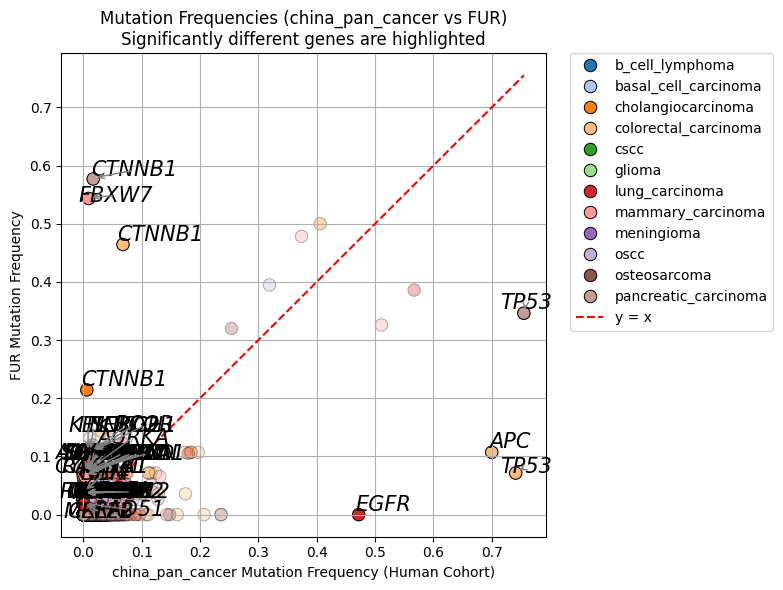

/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]


105 [0.19170862 0.97279444]
156 [-0.14447646  0.70786409]
158 [ 0.07838632 -0.77573021]
131 [-0.97294306  0.71446476]
142 [0.1389991  0.19387992]
231 [-0.27432792 -0.25542747]
243 [ 0.62048192 -0.77420998]
233 [0.19419459 0.16095813]
263 [-0.21124274 -0.21208594]
214 [-0.62755335  0.3242037 ]
240 [0.64738229 0.16566075]
210 [-0.25263031 -0.65015901]
224 [-0.12408455  0.83544345]
61 [0.55042678 0.86511943]
88 [-0.34456797  0.12816263]
329 [-0.75741973 -0.73330169]
335 [-0.02797559  0.55992131]
255 [-0.03716125  0.26821021]
285 [0.57796004 0.74497561]
90 [-0.30476994  0.76594082]
95 [-0.81032188  0.28589306]
130 [-0.56411305 -0.37358832]
149 [-0.47627636  0.09330795]
304 [-0.26188798  0.79659487]
311 [0.13095203 0.58136029]
22 [-0.92838372 -0.55099677]
69 [ 0.69238173 -0.2883969 ]
74 [0.71798564 0.56011064]
107 [-0.26414108 -0.34633845]
126 [ 0.5672504  -0.52927469]


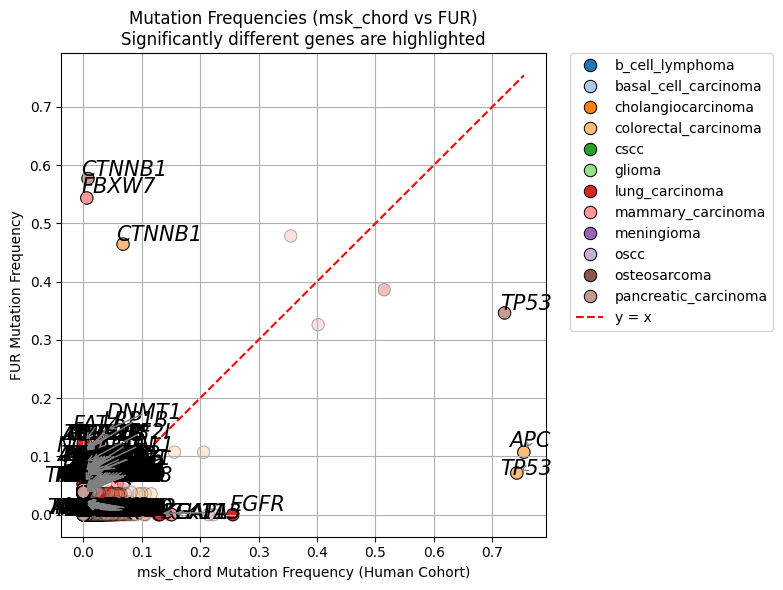

/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[

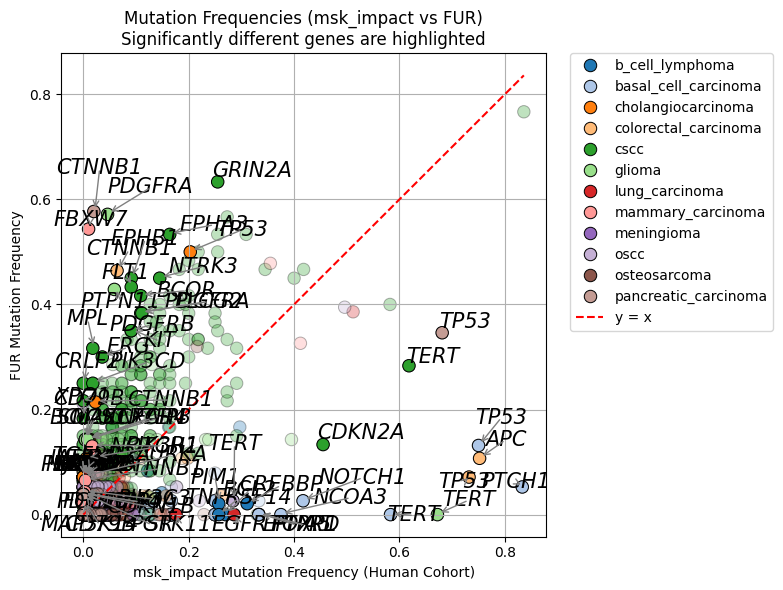

/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_601414/4007326538.py:263: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[

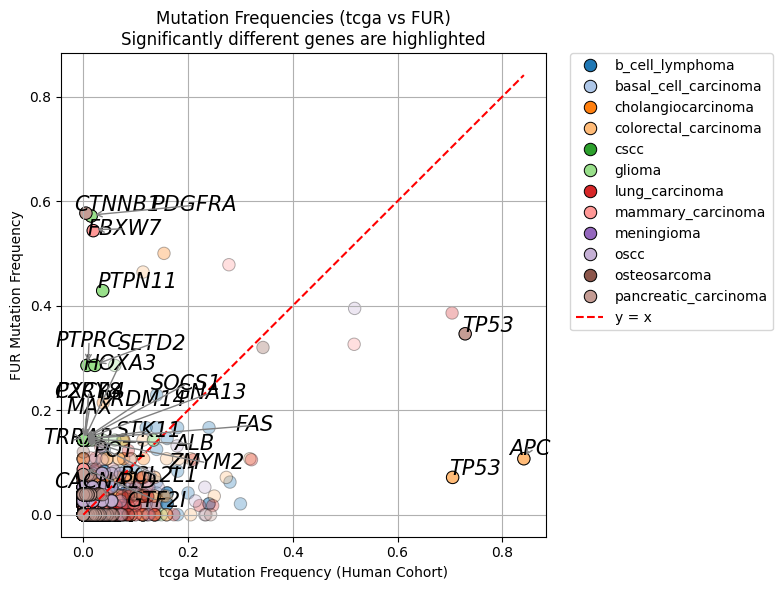

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# ------------------------------
# Define directories and gene list files

data_dir = Path("/lustre/scratch125/casm/team113da/projects/FUR/FUR_analysis/FUR_analysis_cat/human_comparison_figure/data")

# Directories for human cohorts
china_pan_cancer_dir = data_dir / "feb_2025_cohorts/china_pan_cancer"
msk_chord_dir = data_dir / "feb_2025_cohorts/MSK-CHORD"
msk_impact_dir = data_dir / "feb_2025_cohorts/MSK-IMPACT"
tcga_dir = data_dir / "feb_2025_cohorts/TCGA"

# Corresponding gene list files for each cohort
china_gene_list_file = china_pan_cancer_dir / "china_pan_cancer.gene_list.txt"
msk_chord_gene_list_file = msk_chord_dir / "msk_chord.gene_list.txt"
msk_impact_gene_list_file = msk_impact_dir / "msk_impact.gene_list.txt"
tcga_gene_list_file = tcga_dir / "tcga.gene_list.txt"

# Define a list of (cohort directory, gene list file) pairs.
cohorts = [
    (china_pan_cancer_dir, china_gene_list_file),
    (msk_chord_dir, msk_chord_gene_list_file),
    (msk_impact_dir, msk_impact_gene_list_file),
    (tcga_dir, tcga_gene_list_file)
]

# ------------------------------
# Define functions for processing mutation proportions files

def process_mutation_proportions_file(mutation_proportions_file: Path) -> pd.DataFrame:
    """
    Reads a mutation proportions file and extracts the Cohort, Tumour, Gene, and Freq.
    """
    df = pd.read_csv(mutation_proportions_file, sep='\t')
    file_name_parts = mutation_proportions_file.name.split('.')
    cohort_name = file_name_parts[0]
    tumour_type = file_name_parts[1]
    df["Cohort"] = cohort_name
    df["Tumour"] = tumour_type
    df["Freq"] = (
        df["Freq"]
        .str.replace('<', '')
        .str.replace('>', '')
        .str.rstrip('%')
        .astype(float) / 100
    )
    return df[["Cohort", "Tumour", "Gene", "Freq"]]

def process_cohort_dir(cohort_dir: Path, gene_list_file: Path) -> pd.DataFrame:
    """
    Processes all mutation proportions files in a cohort directory,
    merges with the full gene list to ensure one row per gene for each tumour type,
    and fills missing mutation frequencies with 0.
    """
    mutation_files = list(cohort_dir.glob("*.mutation_proportions.txt"))
    df_list = [process_mutation_proportions_file(file) for file in mutation_files]
    if df_list:
        df_cohort = pd.concat(df_list, ignore_index=True)
    else:
        df_cohort = pd.DataFrame(columns=["Cohort", "Tumour", "Gene", "Freq"])
    
    # Read the gene list (assumed one gene per line)
    gene_df = pd.read_csv(gene_list_file, header=None, names=["Gene"])
    
    # For every unique combination of Cohort and Tumour, merge with the full gene list.
    complete_rows = []
    for (cohort, tumour), group in df_cohort.groupby(["Cohort", "Tumour"]):
        merged = gene_df.merge(group, on="Gene", how="left")
        merged["Cohort"] = cohort
        merged["Tumour"] = tumour
        merged["Freq"] = merged["Freq"].fillna(0)
        complete_rows.append(merged)
    
    if complete_rows:
        return pd.concat(complete_rows, ignore_index=True)
    else:
        # If no mutation files exist, create an empty DataFrame with all genes and 0 frequency.
        gene_df["Freq"] = 0
        gene_df["Cohort"] = cohort_dir.name
        gene_df["Tumour"] = "NA"
        return gene_df[["Cohort", "Tumour", "Gene", "Freq"]]

# Process each cohort and combine into a single dataframe.
all_cohort_dfs = [process_cohort_dir(cohort_dir, gene_file) for cohort_dir, gene_file in cohorts]
cbioportal_combined_mutation_proportions_df = pd.concat(all_cohort_dfs, ignore_index=True)
print(cbioportal_combined_mutation_proportions_df.head())

# ------------------------------
# Process FUR MAF files

fur_dir = data_dir / "fur_mafs"
fur_gene_list_file = fur_dir / "fur_cat.gene_list.txt"
fur_mafs = list(fur_dir.glob('*.maf'))

STUDY_ID_TO_TUMOUR_TYPE_DICT = {
    "6555_2711": "lung_carcinoma",
    "6711_2820": "cscc",
    "6712_2822": "oscc",
    "6841_2964": "meningioma",
    "6864_2965": "pancreatic_carcinoma",
    "6945_3142": "cholangiocarcinoma",
    "6973_2987": "osteosarcoma",
    "6982_3135": "b_cell_lymphoma",
    "6990_3065": "mammary_carcinoma",
    "7040_3064": "basal_cell_carcinoma",
    "7097_3073": "colorectal_carcinoma",
    "7098_3140": "glioma"
}

T_CELL_LYMPHOMA_SAMPLES = [
    'CATD0572a', 'CATD0574a', 'CATD0575a',
    'CATD0578a', 'CATD0579a', 'CATD0580a', 
    'CATD0581a', 'CATD0585a', 'CATD0587a',
    'CATD0588a', 'CATD0592a', 'CATD0593a',
    'CATD0596a', 'CATD0598a', 'CATD0601a',
    'CATD0603a', 'CATD0606a', 'CATD0608a',
    'CATD0610a', 'CATD0678a', 'CATD0679a',
    'CATD0680a', 'CATD0682a', 'CATD0683a', 
    'CATD0684a', 'CATD0687a', 'CATD0721a',
    'CATD0722a', 'CATD0724a'
]

dataframes = []
for file in fur_mafs:
    study_id = file.stem.split('.')[0].split('matched_')[1]
    if study_id == '6713_2821':
        continue
    tumour_type = STUDY_ID_TO_TUMOUR_TYPE_DICT.get(study_id)
    df = pd.read_csv(file, sep='\t')
    df['Tumour'] = tumour_type
    if tumour_type == "lymphoma":
        df = df[~df["Sanger_DNA_ID"].isin(T_CELL_LYMPHOMA_SAMPLES)]
    dataframes.append(df)

fur_combined_df = pd.concat(dataframes, ignore_index=True)

def calculate_mutation_proportion_from_maf_df(df):
    """
    Calculate the proportion of unique samples with mutations per gene in each tumour type.
    If Hugo_Symbol is '-', use the 'Gene' column instead.
    """
    required_columns = {'Hugo_Symbol', 'Tumour', 'Tumor_Sample_Barcode', 'Gene'}
    assert required_columns.issubset(df.columns), f"Missing columns: {required_columns - set(df.columns)}"
    
    df['Gene_Final'] = df['Hugo_Symbol'].where(df['Hugo_Symbol'] != '-', df['Gene'])
    total_samples = df.groupby('Tumour')['Tumor_Sample_Barcode'].nunique()
    mutated = df.groupby(['Gene_Final', 'Tumour'])['Tumor_Sample_Barcode'].nunique()
    proportions = mutated / total_samples
    result = proportions.reset_index()
    result.columns = ['Gene', 'Tumour', 'Freq']
    result['Cohort'] = 'FUR'
    return result[['Cohort', 'Gene', 'Tumour', 'Freq']]

fur_mutation_proportion_df = calculate_mutation_proportion_from_maf_df(fur_combined_df)

def merge_with_gene_list(proportion_df, gene_list_file, cohort='FUR'):
    """
    Ensure every gene in the provided gene list appears for each tumour type.
    If a gene is missing in the mutation proportions, its frequency is set to 0.
    """
    gene_df = pd.read_csv(gene_list_file, header=None, names=["Gene"])
    merged_list = []
    for tumour in proportion_df['Tumour'].unique():
        df_tumour = proportion_df[proportion_df['Tumour'] == tumour]
        merged = gene_df.merge(df_tumour, on="Gene", how="left")
        merged["Tumour"] = tumour
        merged["Cohort"] = cohort
        merged["Freq"] = merged["Freq"].fillna(0)
        merged_list.append(merged)
    return pd.concat(merged_list, ignore_index=True)

fur_mutation_proportion_full_df = merge_with_gene_list(fur_mutation_proportion_df, fur_gene_list_file, cohort='FUR')
print(fur_mutation_proportion_full_df.head())

merged_df = pd.merge(
    cbioportal_combined_mutation_proportions_df,
    fur_mutation_proportion_df,
    on=['Gene', 'Tumour'],
    how='inner',
    suffixes=('_cbio', '_fur')
)
print(merged_df.head())

# ------------------------------
# Define sample counts for cBioPortal studies.
cbio_total_samples = {
    ("tcga", "pancreatic_carcinoma"): 285,
    ("tcga", "cholangiocarcinoma"): 26,
    ("tcga", "mammary_carcinoma"): 211,
    ("tcga", "glioma"): 150,
    ("tcga", "b_cell_lymphoma"): 50,
    ("tcga", "osteosarcoma"): 35,
    ("tcga", "oscc"): 56,
    ("tcga", "colorectal_carcinoma"): 44,
    ("tcga", "lung_carcinoma"): 71,
    ("msk_impact", "lung_carcinoma"): 1357,
    ("msk_impact", "mammary_carcinoma"): 1312,
    ("msk_impact", "colorectal_carcinoma"): 965,
    ("msk_impact", "glioma"): 541,
    ("msk_impact", "pancreatic_carcinoma"): 398,
    ("msk_impact", "cholangiocarcinoma"): 172,
    ("msk_impact", "oscc"): 141,
    ("msk_impact", "cscc"): 55,
    ("msk_impact", "basal_cell_carcinoma"): 12,
    ("msk_impact", "osteosarcoma"): 37,
    ("msk_impact", "b_cell_lymphoma"): 74,
    ("msk_impact", "meningioma"): 21,
    ("msk_chord", "lung_carcinoma"): 6434,
    ("msk_chord", "colorectal_carcinoma"): 5389,
    ("msk_chord", "mammary_carcinoma"): 5200,
    ("msk_chord", "pancreatic_carcinoma"): 2746,
    ("china_pan_cancer", "lung_carcinoma"): 2018,
    ("china_pan_cancer", "colorectal_carcinoma"): 1220,
    ("china_pan_cancer", "cholangiocarcinoma"): 508,
    ("china_pan_cancer", "pancreatic_carcinoma"): 461,
    ("china_pan_cancer", "mammary_carcinoma"): 321,
    ("china_pan_cancer", "osteosarcoma"): 122,
    ("china_pan_cancer", "oscc"): 94,
}

fur_total_samples = fur_combined_df.groupby('Tumour')['Tumor_Sample_Barcode'].nunique().to_dict()

def two_proportion_ztest(x1, n1, x2, n2):
    """
    Perform a two-proportion z-test comparing proportions p1 = x1/n1 and p2 = x2/n2.
    Returns the two-tailed p-value.
    """
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return 1.0
    z = (p1 - p2) / se
    return 2 * (1 - norm.cdf(abs(z)))

# ------------------------------
# Ensure consistent colouring for tumour types across all plots.
all_tumours = set(cbioportal_combined_mutation_proportions_df['Tumour'].unique()).union(
    set(fur_mutation_proportion_full_df['Tumour'].unique())
)
global_tumour_list = sorted(all_tumours)
global_palette = dict(zip(global_tumour_list, sns.color_palette("tab20", len(global_tumour_list))))

LABEL_THRESHOLD = 0.01

for cbio_cohort in cbioportal_combined_mutation_proportions_df['Cohort'].unique():
    cbio_cohort_df = cbioportal_combined_mutation_proportions_df[
        cbioportal_combined_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    merged_list = []
    for tumour in cbio_cohort_df['Tumour'].unique():
        cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
        fur_subset = fur_mutation_proportion_full_df[fur_mutation_proportion_full_df['Tumour'] == tumour]
        
        merged_df = pd.merge(
            cbio_subset,
            fur_subset,
            on="Gene",
            suffixes=('_cbio', '_fur')
        )
        merged_df['Tumour'] = tumour
        if not merged_df.empty:
            merged_list.append(merged_df)
    
    if merged_list:
        cohort_merged = pd.concat(merged_list, ignore_index=True)
        
        def compute_p_val(row):
            tumour = row['Tumour']
            n1 = cbio_total_samples.get((cbio_cohort, tumour), np.nan)
            n2 = fur_total_samples.get(tumour, np.nan)
            if pd.isna(n1) or pd.isna(n2) or n1 == 0 or n2 == 0:
                return 1.0
            x1 = round(row['Freq_cbio'] * n1)
            x2 = round(row['Freq_fur'] * n2)
            return two_proportion_ztest(x1, n1, x2, n2)
        
        cohort_merged['p_val'] = cohort_merged.apply(compute_p_val, axis=1)
        _, pvals_corrected, _, _ = multipletests(cohort_merged['p_val'], alpha=0.05, method='fdr_bh')
        cohort_merged['p_adj'] = pvals_corrected
        cohort_merged['significant'] = cohort_merged['p_adj'] < 0.05
        
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=cohort_merged,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            hue_order=global_tumour_list,
            palette=global_palette,
            s=80,
            edgecolor='k',
            alpha=0.3,
            legend='brief'
        )
        
        sig_data = cohort_merged[cohort_merged['significant']]
        sns.scatterplot(
            data=sig_data,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            hue_order=global_tumour_list,
            palette=global_palette,
            s=80,
            edgecolor='k',
            alpha=1.0,
            legend=False
        )
        
        sig_data_for_label = sig_data[
            ~((sig_data['Freq_cbio'] < LABEL_THRESHOLD) &
              (sig_data['Freq_fur'] < LABEL_THRESHOLD))
        ]
        
        texts = []
        for _, row in sig_data_for_label.iterrows():
            txt = plt.text(
                row['Freq_cbio'] + 0.002,
                row['Freq_fur'] + 0.002,
                row['Gene'],
                fontsize=15,
                fontstyle='italic'
            )
            texts.append(txt)
        
        adjust_text(
            texts,
            arrowprops=dict(arrowstyle='->', color='gray', lw=1),
            avoid_points=True,
            expand_text=(1.1, 1.1),
            expand_points=(2, 2),
            force_text=1.0,
            force_points=0.5,
            only_move={'text': 'xy'},
            lim=1000
        )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency (Human Cohort)')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(f'Mutation Frequencies ({cbio_cohort} vs FUR)\nSignificantly different genes are highlighted')
        max_val = max(cohort_merged['Freq_cbio'].max(), cohort_merged['Freq_fur'].max())
        plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y = x')
        
        # Retrieve current legend handles and labels, then set handle alpha to 1.0 and recreate legend.
        handles, labels = plt.gca().get_legend_handles_labels()
        for handle in handles:
            if hasattr(handle, "set_alpha"):
                handle.set_alpha(1.0)
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        plt.grid(True)
        plt.tight_layout()
        pdf_filename = f"Mutation_Frequencies_{cbio_cohort}_vs_FUR.pdf"
        plt.savefig(pdf_filename)
        plt.show()
    else:
        print(f"No overlapping gene data found for {cbio_cohort}.")


     Gene            Cohort              Tumour   Freq
0    ABL1  china_pan_cancer  cholangiocarcinoma  0.008
1    ABL2  china_pan_cancer  cholangiocarcinoma  0.014
2  ACVR1B  china_pan_cancer  cholangiocarcinoma  0.016
3  ACVR2A  china_pan_cancer  cholangiocarcinoma  0.030
4  ADAM29  china_pan_cancer  cholangiocarcinoma  0.008
       Gene Cohort Tumour      Freq
0      ABI1    FUR   cscc  0.032258
1      ABL1    FUR   cscc  0.258065
2      ABL2    FUR   cscc  0.145161
3  ABRAXAS1    FUR   cscc  0.016129
4     ACKR3    FUR   cscc  0.080645
     Gene       Cohort_cbio              Tumour  Freq_cbio Cohort_fur  \
0    ABL1  china_pan_cancer  cholangiocarcinoma      0.008        FUR   
1  ACVR2A  china_pan_cancer  cholangiocarcinoma      0.030        FUR   
2     APC  china_pan_cancer  cholangiocarcinoma      0.031        FUR   
3      AR  china_pan_cancer  cholangiocarcinoma      0.018        FUR   
4  ARID1A  china_pan_cancer  cholangiocarcinoma      0.185        FUR   

   Freq_fur  
0

/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[

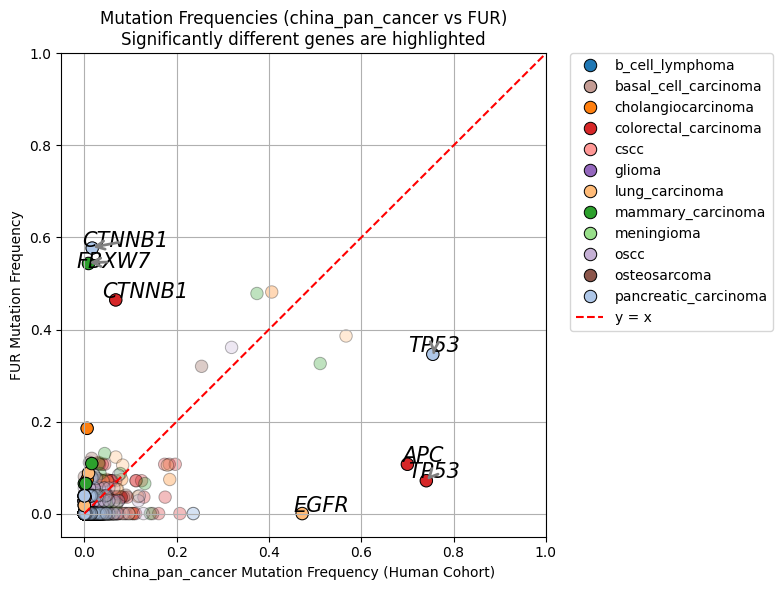

For china_pan_cancer, 22 out of 2541 matched genes (0.87%) showed statistically significant different mutational frequencies (Table Sx)


/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]


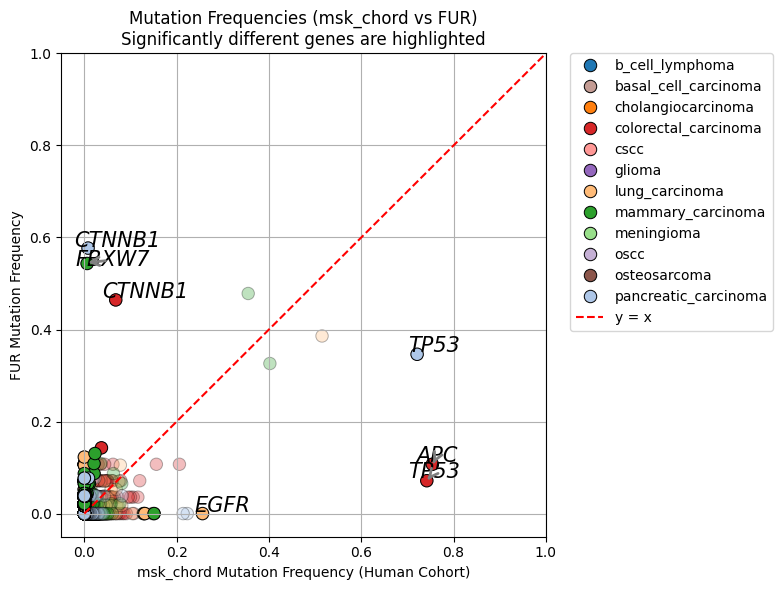

For msk_chord, 338 out of 3588 matched genes (9.42%) showed statistically significant different mutational frequencies (Table Sx)


/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[

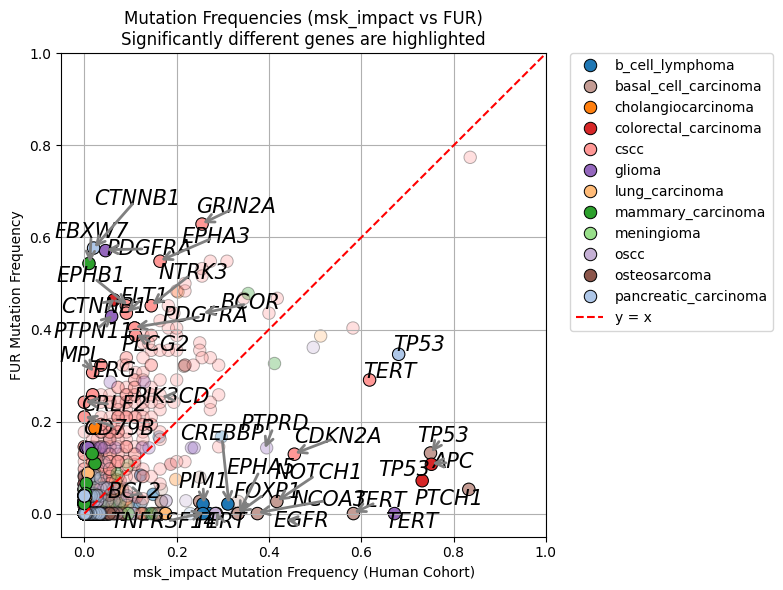

For msk_impact, 57 out of 4128 matched genes (1.38%) showed statistically significant different mutational frequencies (Table Sx)


/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
/tmp/ipykernel_798406/1938651007.py:286: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cbio_subset = cbio_cohort_df[

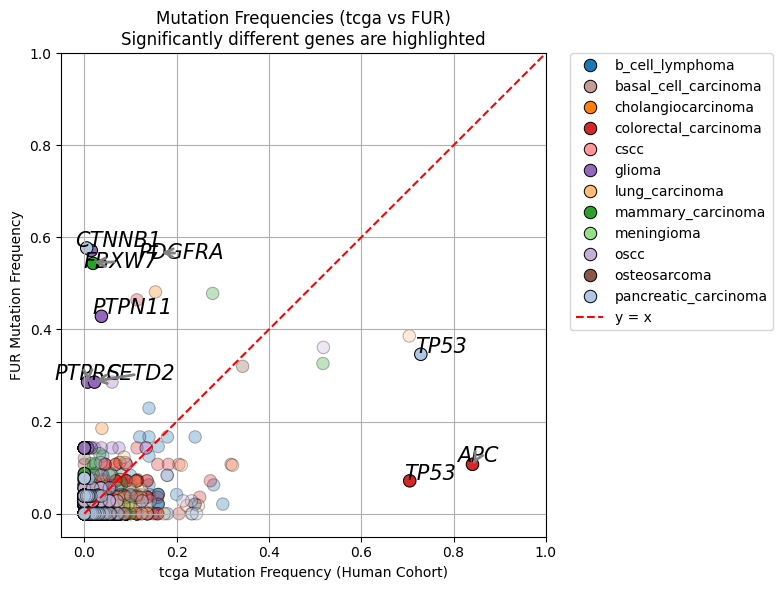

For tcga, 25 out of 8091 matched genes (0.31%) showed statistically significant different mutational frequencies (Table Sx)
Supplementary table created: Supplementary_Table_All_Genes.csv


In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# ------------------------------
# Define directories and gene list files

data_dir = Path("/lustre/scratch125/casm/team113da/projects/FUR/FUR_analysis/FUR_analysis_cat/human_comparison_figure/data")

# Directories for human cohorts
china_pan_cancer_dir = data_dir / "feb_2025_cohorts/china_pan_cancer"
msk_chord_dir = data_dir / "feb_2025_cohorts/MSK-CHORD"
msk_impact_dir = data_dir / "feb_2025_cohorts/MSK-IMPACT"
tcga_dir = data_dir / "feb_2025_cohorts/TCGA"

# Corresponding gene list files for each cohort
china_gene_list_file = china_pan_cancer_dir / "china_pan_cancer.gene_list.txt"
msk_chord_gene_list_file = msk_chord_dir / "msk_chord.gene_list.txt"
msk_impact_gene_list_file = msk_impact_dir / "msk_impact.gene_list.txt"
tcga_gene_list_file = tcga_dir / "tcga.gene_list.txt"

# Define a list of (cohort directory, gene list file) pairs.
cohorts = [
    (china_pan_cancer_dir, china_gene_list_file),
    (msk_chord_dir, msk_chord_gene_list_file),
    (msk_impact_dir, msk_impact_gene_list_file),
    (tcga_dir, tcga_gene_list_file)
]

# ------------------------------
# Define functions for processing mutation proportions files

def process_mutation_proportions_file(mutation_proportions_file: Path) -> pd.DataFrame:
    """
    Reads a mutation proportions file and extracts the Cohort, Tumour, Gene, and Freq.
    """
    df = pd.read_csv(mutation_proportions_file, sep='\t')
    file_name_parts = mutation_proportions_file.name.split('.')
    cohort_name = file_name_parts[0]
    tumour_type = file_name_parts[1]
    df["Cohort"] = cohort_name
    df["Tumour"] = tumour_type
    df["Freq"] = (
        df["Freq"]
        .str.replace('<', '')
        .str.replace('>', '')
        .str.rstrip('%')
        .astype(float) / 100
    )
    return df[["Cohort", "Tumour", "Gene", "Freq"]]

def process_cohort_dir(cohort_dir: Path, gene_list_file: Path) -> pd.DataFrame:
    """
    Processes all mutation proportions files in a cohort directory,
    merges with the full gene list to ensure one row per gene for each tumour type,
    and fills missing mutation frequencies with 0.
    """
    mutation_files = list(cohort_dir.glob("*.mutation_proportions.txt"))
    df_list = [process_mutation_proportions_file(file) for file in mutation_files]
    if df_list:
        df_cohort = pd.concat(df_list, ignore_index=True)
    else:
        df_cohort = pd.DataFrame(columns=["Cohort", "Tumour", "Gene", "Freq"])
    
    # Read the gene list (assumed one gene per line)
    gene_df = pd.read_csv(gene_list_file, header=None, names=["Gene"])
    
    # For every unique combination of Cohort and Tumour, merge with the full gene list.
    complete_rows = []
    for (cohort, tumour), group in df_cohort.groupby(["Cohort", "Tumour"]):
        merged = gene_df.merge(group, on="Gene", how="left")
        merged["Cohort"] = cohort
        merged["Tumour"] = tumour
        merged["Freq"] = merged["Freq"].fillna(0)
        complete_rows.append(merged)
    
    if complete_rows:
        return pd.concat(complete_rows, ignore_index=True)
    else:
        # If no mutation files exist, create an empty DataFrame with all genes and 0 frequency.
        gene_df["Freq"] = 0
        gene_df["Cohort"] = cohort_dir.name
        gene_df["Tumour"] = "NA"
        return gene_df[["Cohort", "Tumour", "Gene", "Freq"]]

# Process each cohort and combine into a single dataframe.
all_cohort_dfs = [process_cohort_dir(cohort_dir, gene_file) for cohort_dir, gene_file in cohorts]
cbioportal_combined_mutation_proportions_df = pd.concat(all_cohort_dfs, ignore_index=True)
print(cbioportal_combined_mutation_proportions_df.head())

# ------------------------------
# Process FUR MAF files

fur_dir = data_dir / "fur_mafs"
fur_gene_list_file = fur_dir / "fur_cat.gene_list.txt"
fur_mafs = list(fur_dir.glob('*.maf'))

STUDY_ID_TO_TUMOUR_TYPE_DICT = {
    "6555_2711": "lung_carcinoma",
    "6711_2820": "cscc",
    "6712_2822": "oscc",
    "6841_2964": "meningioma",
    "6864_2965": "pancreatic_carcinoma",
    "6945_3142": "cholangiocarcinoma",
    "6973_2987": "osteosarcoma",
    "6982_3135": "b_cell_lymphoma",
    "6990_3065": "mammary_carcinoma",
    "7040_3064": "basal_cell_carcinoma",
    "7097_3073": "colorectal_carcinoma",
    "7098_3140": "glioma"
}

T_CELL_LYMPHOMA_SAMPLES = [
    'CATD0572a', 'CATD0574a', 'CATD0575a',
    'CATD0578a', 'CATD0579a', 'CATD0580a', 
    'CATD0581a', 'CATD0585a', 'CATD0587a',
    'CATD0588a', 'CATD0592a', 'CATD0593a',
    'CATD0596a', 'CATD0598a', 'CATD0601a',
    'CATD0603a', 'CATD0606a', 'CATD0608a',
    'CATD0610a', 'CATD0678a', 'CATD0679a',
    'CATD0680a', 'CATD0682a', 'CATD0683a', 
    'CATD0684a', 'CATD0687a', 'CATD0721a',
    'CATD0722a', 'CATD0724a'
]

dataframes = []
for file in fur_mafs:
    study_id = file.stem.split('.')[0].split('matched_')[1].replace('_2025_02_10', '')
    if study_id == '6713_2821':
        continue
    tumour_type = STUDY_ID_TO_TUMOUR_TYPE_DICT.get(study_id)
    df = pd.read_csv(file, sep='\t')
    df['Tumour'] = tumour_type
    if tumour_type == "lymphoma":
        df = df[~df["Sanger_DNA_ID"].isin(T_CELL_LYMPHOMA_SAMPLES)]
    dataframes.append(df)

fur_combined_df = pd.concat(dataframes, ignore_index=True)

def calculate_mutation_proportion_from_maf_df(df):
    """
    Calculate the proportion of unique samples with mutations per gene in each tumour type.
    If Hugo_Symbol is '-', use the 'Gene' column instead.
    """
    required_columns = {'Hugo_Symbol', 'Tumour', 'Tumor_Sample_Barcode', 'Gene'}
    assert required_columns.issubset(df.columns), f"Missing columns: {required_columns - set(df.columns)}"
    
    df['Gene_Final'] = df['Hugo_Symbol'].where(df['Hugo_Symbol'] != '-', df['Gene'])
    total_samples = df.groupby('Tumour')['Tumor_Sample_Barcode'].nunique()
    mutated = df.groupby(['Gene_Final', 'Tumour'])['Tumor_Sample_Barcode'].nunique()
    proportions = mutated / total_samples
    result = proportions.reset_index()
    result.columns = ['Gene', 'Tumour', 'Freq']
    result['Cohort'] = 'FUR'
    return result[['Cohort', 'Gene', 'Tumour', 'Freq']]

fur_mutation_proportion_df = calculate_mutation_proportion_from_maf_df(fur_combined_df)

def merge_with_gene_list(proportion_df, gene_list_file, cohort='FUR'):
    """
    Ensure every gene in the provided gene list appears for each tumour type.
    If a gene is missing in the mutation proportions, its frequency is set to 0.
    """
    gene_df = pd.read_csv(gene_list_file, header=None, names=["Gene"])
    merged_list = []
    for tumour in proportion_df['Tumour'].unique():
        df_tumour = proportion_df[proportion_df['Tumour'] == tumour]
        merged = gene_df.merge(df_tumour, on="Gene", how="left")
        merged["Tumour"] = tumour
        merged["Cohort"] = cohort
        merged["Freq"] = merged["Freq"].fillna(0)
        merged_list.append(merged)
    return pd.concat(merged_list, ignore_index=True)

fur_mutation_proportion_full_df = merge_with_gene_list(fur_mutation_proportion_df, fur_gene_list_file, cohort='FUR')
print(fur_mutation_proportion_full_df.head())

merged_df = pd.merge(
    cbioportal_combined_mutation_proportions_df,
    fur_mutation_proportion_df,
    on=['Gene', 'Tumour'],
    how='inner',
    suffixes=('_cbio', '_fur')
)
print(merged_df.head())

# ------------------------------
# Define sample counts for cBioPortal studies.
cbio_total_samples = {
    ("tcga", "pancreatic_carcinoma"): 285,
    ("tcga", "cholangiocarcinoma"): 26,
    ("tcga", "mammary_carcinoma"): 211,
    ("tcga", "glioma"): 150,
    ("tcga", "b_cell_lymphoma"): 50,
    ("tcga", "osteosarcoma"): 35,
    ("tcga", "oscc"): 56,
    ("tcga", "colorectal_carcinoma"): 44,
    ("tcga", "lung_carcinoma"): 71,
    ("msk_impact", "lung_carcinoma"): 1357,
    ("msk_impact", "mammary_carcinoma"): 1312,
    ("msk_impact", "colorectal_carcinoma"): 965,
    ("msk_impact", "glioma"): 541,
    ("msk_impact", "pancreatic_carcinoma"): 398,
    ("msk_impact", "cholangiocarcinoma"): 172,
    ("msk_impact", "oscc"): 141,
    ("msk_impact", "cscc"): 55,
    ("msk_impact", "basal_cell_carcinoma"): 12,
    ("msk_impact", "osteosarcoma"): 37,
    ("msk_impact", "b_cell_lymphoma"): 74,
    ("msk_impact", "meningioma"): 21,
    ("msk_chord", "lung_carcinoma"): 6434,
    ("msk_chord", "colorectal_carcinoma"): 5389,
    ("msk_chord", "mammary_carcinoma"): 5200,
    ("msk_chord", "pancreatic_carcinoma"): 2746,
    ("china_pan_cancer", "lung_carcinoma"): 2018,
    ("china_pan_cancer", "colorectal_carcinoma"): 1220,
    ("china_pan_cancer", "cholangiocarcinoma"): 508,
    ("china_pan_cancer", "pancreatic_carcinoma"): 461,
    ("china_pan_cancer", "mammary_carcinoma"): 321,
    ("china_pan_cancer", "osteosarcoma"): 122,
    ("china_pan_cancer", "oscc"): 94,
}

fur_total_samples = fur_combined_df.groupby('Tumour')['Tumor_Sample_Barcode'].nunique().to_dict()

def two_proportion_ztest(x1, n1, x2, n2):
    """
    Perform a two-proportion z-test comparing proportions p1 = x1/n1 and p2 = x2/n2.
    Returns the two-tailed p-value.
    """
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    se = math.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return 1.0
    z = (p1 - p2) / se
    return 2 * (1 - norm.cdf(abs(z)))

# ------------------------------
# Ensure consistent colouring for tumour types across all plots.
all_tumours = set(cbioportal_combined_mutation_proportions_df['Tumour'].unique()).union(
    set(fur_mutation_proportion_full_df['Tumour'].unique())
)
global_tumour_list = sorted(all_tumours)
global_palette = dict(zip(global_tumour_list, sns.color_palette("tab20", len(global_tumour_list))))

# --- Swap colours for specific tumour types ---
# Swap: Mammary carcinoma <--> cSCC
if 'mammary_carcinoma' in global_palette and 'cscc' in global_palette:
    global_palette['mammary_carcinoma'], global_palette['cscc'] = global_palette['cscc'], global_palette['mammary_carcinoma']

# Swap: Pancreatic carcinoma <--> Basal cell carcinoma
if 'pancreatic_carcinoma' in global_palette and 'basal_cell_carcinoma' in global_palette:
    global_palette['pancreatic_carcinoma'], global_palette['basal_cell_carcinoma'] = global_palette['basal_cell_carcinoma'], global_palette['pancreatic_carcinoma']

# Swap: Colorectal carcinoma <--> Lung carcinoma
if 'colorectal_carcinoma' in global_palette and 'lung_carcinoma' in global_palette:
    global_palette['colorectal_carcinoma'], global_palette['lung_carcinoma'] = global_palette['lung_carcinoma'], global_palette['colorectal_carcinoma']

# Swap: Meningioma <--> glioma
if 'meningioma' in global_palette and 'glioma' in global_palette:
    global_palette['meningioma'], global_palette['glioma'] = global_palette['glioma'], global_palette['meningioma']


# Set a minimum frequency threshold for labelling.
min_label_frequency = 0.20

# ------------------------------
# Process each cBioPortal cohort and collect complete results (both significant and non-significant genes).
all_cohort_results = []

for cbio_cohort in cbioportal_combined_mutation_proportions_df['Cohort'].unique():
    cbio_cohort_df = cbioportal_combined_mutation_proportions_df[
        cbioportal_combined_mutation_proportions_df['Cohort'] == cbio_cohort
    ]
    
    merged_list = []
    for tumour in cbio_cohort_df['Tumour'].unique():
        cbio_subset = cbio_cohort_df[cbioportal_combined_mutation_proportions_df['Tumour'] == tumour]
        fur_subset = fur_mutation_proportion_full_df[fur_mutation_proportion_full_df['Tumour'] == tumour]
        
        merged_tumour_df = pd.merge(
            cbio_subset,
            fur_subset,
            on="Gene",
            suffixes=('_cbio', '_fur')
        )
        merged_tumour_df['Tumour'] = tumour
        if not merged_tumour_df.empty:
            merged_list.append(merged_tumour_df)
    
    if merged_list:
        cohort_merged = pd.concat(merged_list, ignore_index=True)
        
        def compute_p_val(row):
            tumour = row['Tumour']
            n1 = cbio_total_samples.get((cbio_cohort, tumour), np.nan)
            n2 = fur_total_samples.get(tumour, np.nan)
            if pd.isna(n1) or pd.isna(n2) or n1 == 0 or n2 == 0:
                return 1.0
            x1 = round(row['Freq_cbio'] * n1)
            x2 = round(row['Freq_fur'] * n2)
            return two_proportion_ztest(x1, n1, x2, n2)
        
        cohort_merged['p_val'] = cohort_merged.apply(compute_p_val, axis=1)
        _, pvals_corrected, _, _ = multipletests(cohort_merged['p_val'], alpha=0.05, method='fdr_bh')
        cohort_merged['p_adj'] = pvals_corrected
        cohort_merged['significant'] = cohort_merged['p_adj'] < 0.05
        
        # Plotting mutation frequencies with consistent axes (0 -> 1)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=cohort_merged,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            hue_order=global_tumour_list,
            palette=global_palette,
            s=80,
            edgecolor='k',
            alpha=0.3,
            legend='brief'
        )
        
        sig_data = cohort_merged[cohort_merged['significant']]
        sns.scatterplot(
            data=sig_data,
            x='Freq_cbio',
            y='Freq_fur',
            hue='Tumour',
            hue_order=global_tumour_list,
            palette=global_palette,
            s=80,
            edgecolor='k',
            alpha=1.0,
            legend=False
        )
        
        # Label only those significant genes above the frequency threshold.
        sig_data_for_label = sig_data[
            (sig_data['Freq_cbio'] >= min_label_frequency) |
            (sig_data['Freq_fur'] >= min_label_frequency)
        ]
        texts = []
        for _, row in sig_data_for_label.iterrows():
            txt = plt.text(
                row['Freq_cbio'] + 0.002,
                row['Freq_fur'] + 0.002,
                row['Gene'],
                fontsize=15,
                fontstyle='italic'
            )
            texts.append(txt)
        adjust_text(
            texts,
            arrowprops=dict(
                arrowstyle='->',
                color='gray',
                lw=2,
                mutation_scale=15,
                shrinkA=5,
                shrinkB=50
            ),
            avoid_points=True,
            expand_text=(50, 50),
            expand_points=(2, 2),
            force_text=2.0,
            force_points=100.0,
            only_move={'text': 'xy'},
            lim=1000
        )
        
        plt.xlabel(f'{cbio_cohort} Mutation Frequency (Human Cohort)')
        plt.ylabel('FUR Mutation Frequency')
        plt.title(f'Mutation Frequencies ({cbio_cohort} vs FUR)\nSignificantly different genes are highlighted')
        # Set axes limits to be consistent (0 to 1)
        plt.xlim(-0.05, 1)
        plt.ylim(-0.05, 1)
        # Also plot y = x reference line.
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='y = x')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        for handle in handles:
            if hasattr(handle, "set_alpha"):
                handle.set_alpha(1.0)
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        plt.grid(True)
        plt.tight_layout()
        pdf_filename = f"Mutation_Frequencies_{cbio_cohort}_vs_FUR.pdf"
        plt.savefig(pdf_filename)
        plt.show()
        
        # Print summary statistics.
        for cohort in cohort_merged['Cohort_cbio'].unique():
            total_genes = len(cohort_merged[cohort_merged['Cohort_cbio'] == cohort]['Gene'])
            significant_genes = len(cohort_merged[(cohort_merged['Cohort_cbio'] == cohort) & (cohort_merged['significant'])]['Gene'])
            percentage = significant_genes / total_genes * 100
            print(f"For {cohort}, {significant_genes} out of {total_genes} matched genes ({percentage:.2f}%) showed statistically significant different mutational frequencies (Table Sx)")
        
        # Append the complete results for this cohort.
        all_cohort_results.append(cohort_merged)
    else:
        print(f"No overlapping gene data found for {cbio_cohort}.")

# Create the supplementary table including both significant and non-significant genes.
if all_cohort_results:
    supplementary_table = pd.concat(all_cohort_results, ignore_index=True)
    # Use the cBioPortal cohort name for consistency.
    supplementary_table['Cohort'] = supplementary_table['Cohort_cbio']
    supplementary_table = supplementary_table[[
        'Cohort', 'Tumour', 'Gene', 
        'Freq_cbio', 'Freq_fur', 
        'p_val', 'p_adj', 'significant'
    ]]
    supplementary_table.to_csv("Supplementary_Table_All_Genes.csv", index=False)
    print("Supplementary table created: Supplementary_Table_All_Genes.csv")
else:
    print("No gene data found.")